# Models

In [122]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy
import math
import shap 
import tensorflow as tf
import matplotlib.pyplot as plt
import lightgbm as ltb
import matplotlib.patches as mpatches

from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

numpy.set_printoptions(threshold=sys.maxsize)


In [2]:
# load pre porcessed data
df = pd.read_csv('data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data

df.drop(df[df.DKAPast12mos == 2].index, inplace=True)


In [5]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

166

### for DKA events prediction pre processing


In [6]:
y_label = 'DKAPast12mos' 

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [9]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[2.0, 3.0, 0.0, 1.0]

In [10]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [11]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']


df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CancPancr,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872


# Divide Dataset

In [12]:
df=df.drop('PtID', axis = 1)

In [13]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [14]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CancPancr,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [15]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [16]:
Y.unique()

array([1., 0.])

# Feature Selection

In [17]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [18]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [19]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 150 4478]
Test -  [0. 1.] [  50 1493]


# Imputations

<AxesSubplot:>

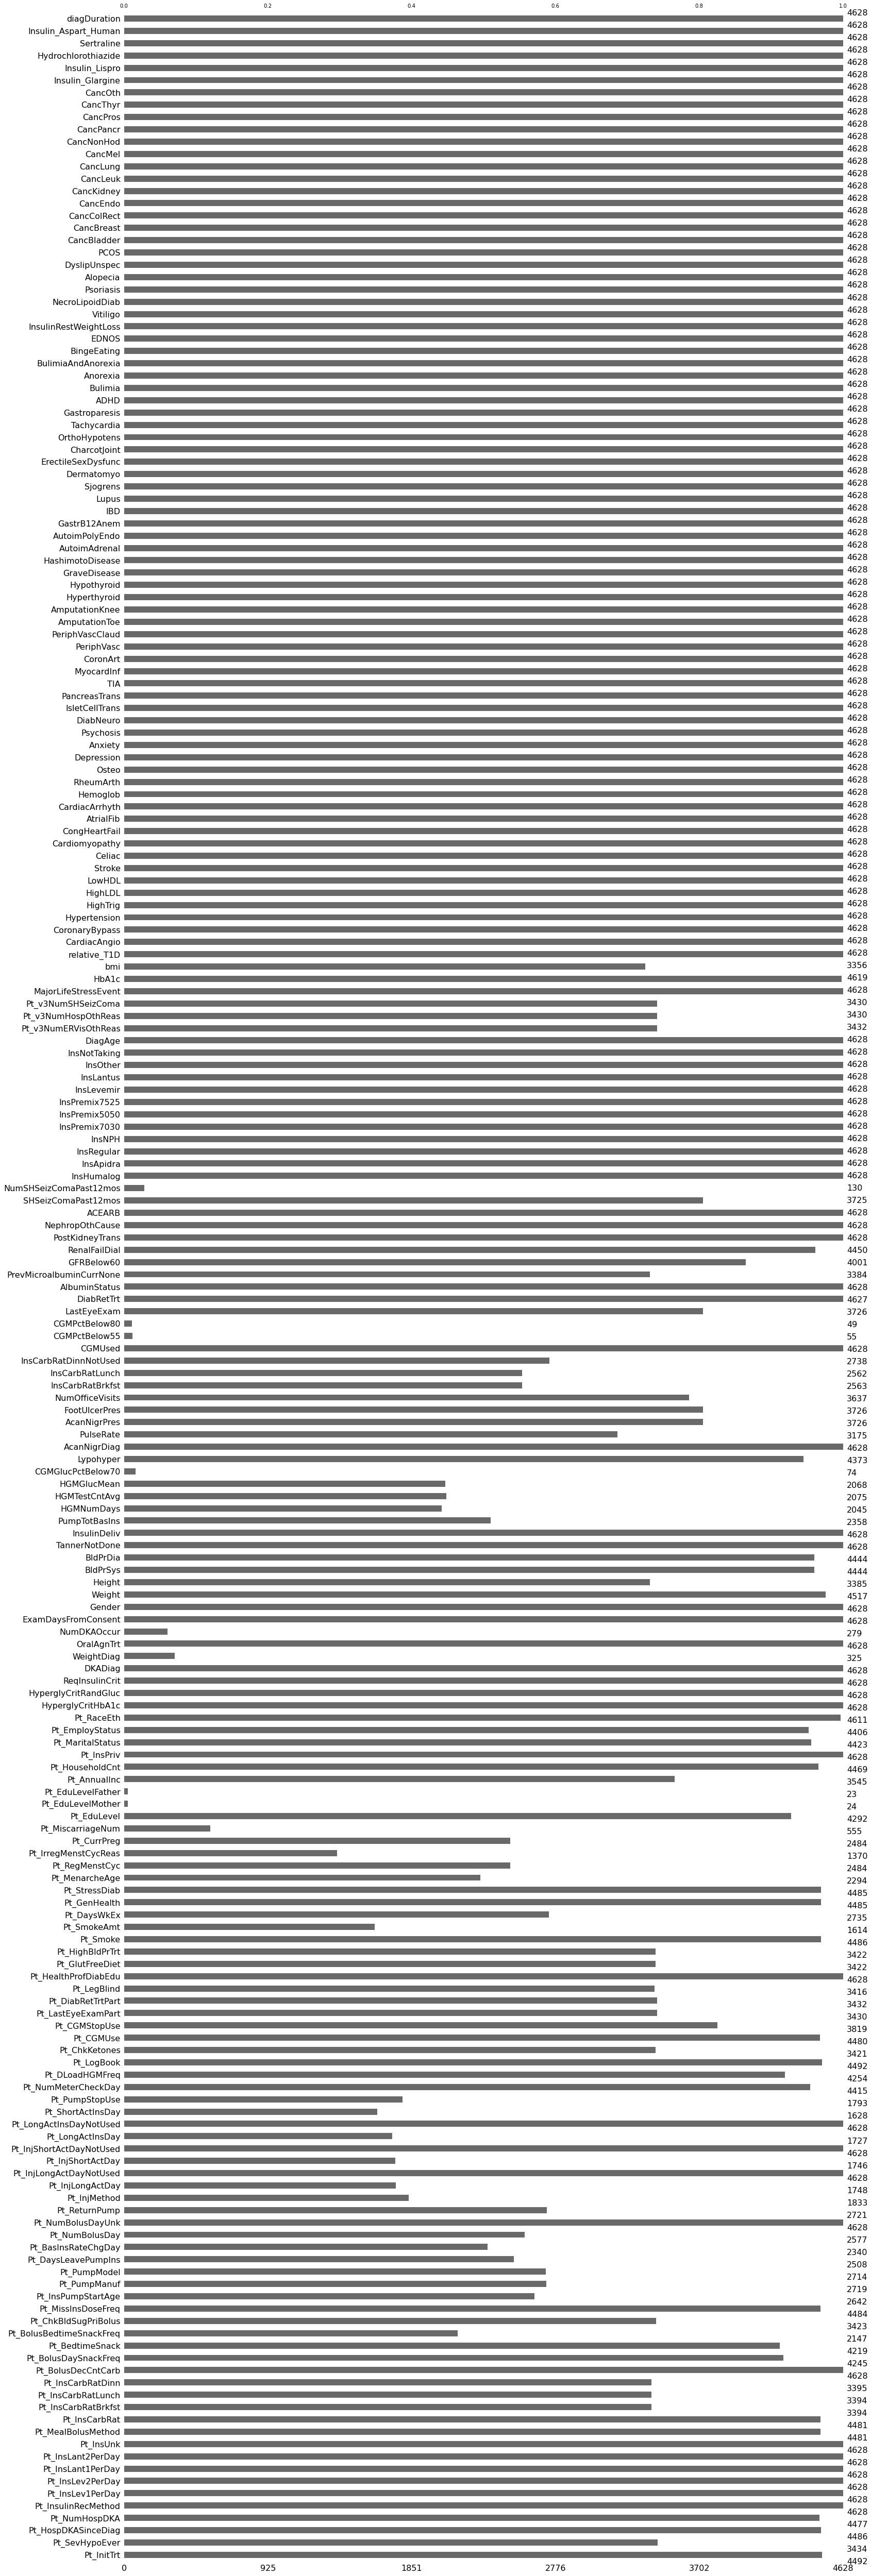

In [20]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [21]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumDKAOccur' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumDKAOccur'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumDKAOccur'], axis=1)
    
if('Pt_NumHospDKA' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_NumHospDKA'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_NumHospDKA'], axis=1)
    

In [23]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



def cross_val_with_missing_val(model,n_splits=5):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1

    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model


### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.968682505399568, doublecheck: 0.968682505399568
Accuracy for the fold no. 2 on the test set: 0.9676025917926566, doublecheck: 0.9676025917926566
Accuracy for the fold no. 3 on the test set: 0.9665226781857451, doublecheck: 0.9665226781857451
Accuracy for the fold no. 4 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Accuracy for the fold no. 5 on the test set: 0.9675675675675676, doublecheck: 0.9675675675675676
Cross validation mean accuracy 0.967588582102621

 
 ===========   Train Dataset    =============
train ROC score 0.9520120589548905
Threshold value is: 0.9315912948823173


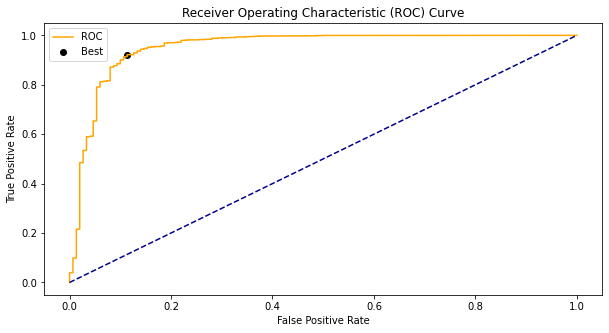

accuracy score:  92.07000864304236
              precision    recall  f1-score   support

         0.0       0.28      0.89      0.42       150
         1.0       1.00      0.92      0.96      4478

    accuracy                           0.92      4628
   macro avg       0.64      0.90      0.69      4628
weighted avg       0.97      0.92      0.94      4628



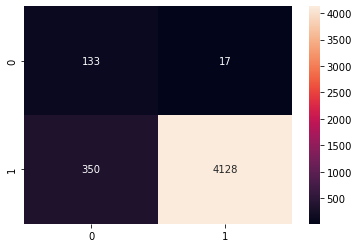

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9659720429104348


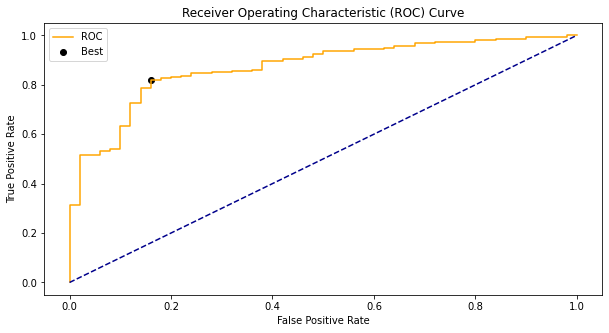

accuracy score:  82.17757615035644
              precision    recall  f1-score   support

         0.0       0.14      0.84      0.23        50
         1.0       0.99      0.82      0.90      1493

    accuracy                           0.82      1543
   macro avg       0.56      0.83      0.57      1543
weighted avg       0.97      0.82      0.88      1543



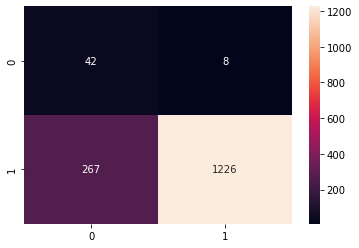

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8703


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.84       0.82116544]
average accuracy:  0.8305827193569992
f1 0.8217757615035645


In [24]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True, 
                         learning_rate = 0.03, 
#                          scale_pos_weight=7,
#                          is_balanced = False,
                         max_depth =4, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test, average = 'micro'))

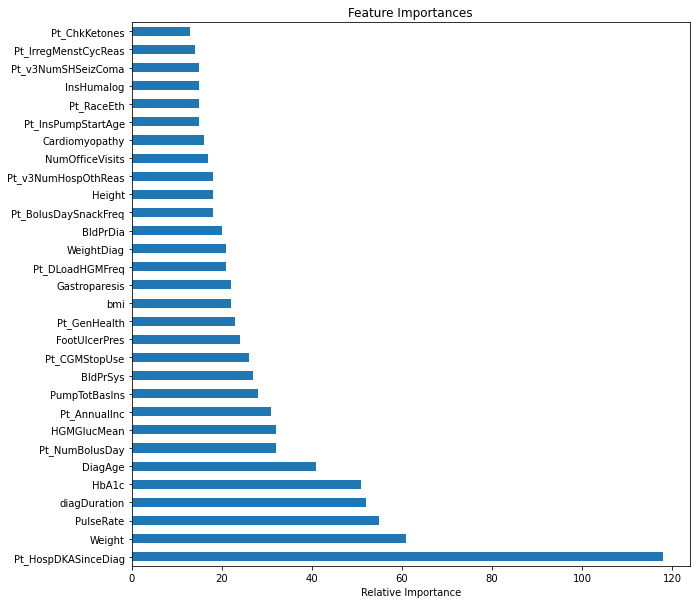

<Figure size 432x288 with 0 Axes>

In [25]:

# feature importance graph of XGB
plt.figure(figsize=(10,10))

plt.title('Feature Importances')
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(30).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.show()
plt.savefig('fiDKA.png')

In [125]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive DKA', alpha=1, color='k', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative DKA', alpha=0.6, color='y', density=True)
    plt.xlabel('Predict probability', fontsize=10)
    plt.ylabel('Number of samples in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.DKAPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=50, c=colormap[categories], alpha=0.5)

    plt.axhline(y=thresh1, color='r')
    plt.axhline(y=thresh2, color = 'g', alpha=0.5)
    
    plt.axhspan(0, thresh1, facecolor='red', alpha=0.05)
    plt.axhspan(thresh1, thresh2, facecolor='yellow', alpha=0.05)
    plt.axhspan(thresh2, 1, facecolor='green', alpha=0.05)


    plt.xlabel('Observations', fontsize=10)
    plt.ylabel('Probability of having DKA occurences', fontsize=10)
    
    k_patch = mpatches.Patch(color='k', label='Positive DKA')
    y_patch = mpatches.Patch(color='y', label='Negative DKA')
    plt.legend(handles=[k_patch, y_patch])

    plt.savefig("yk.png")
    plt.show()


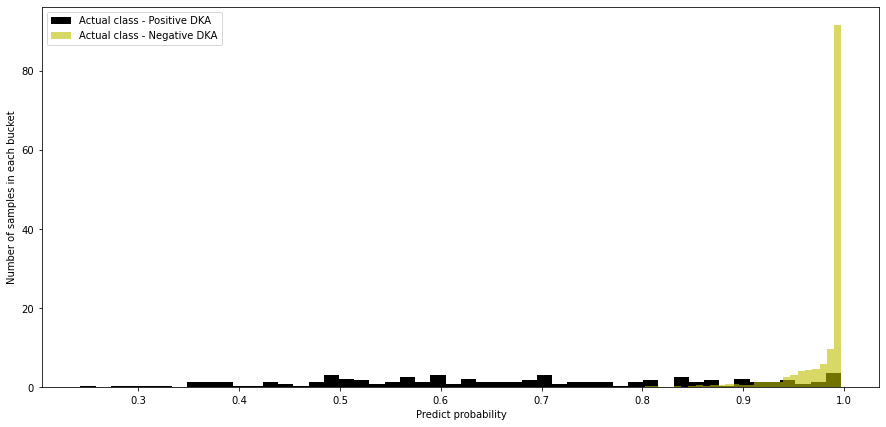

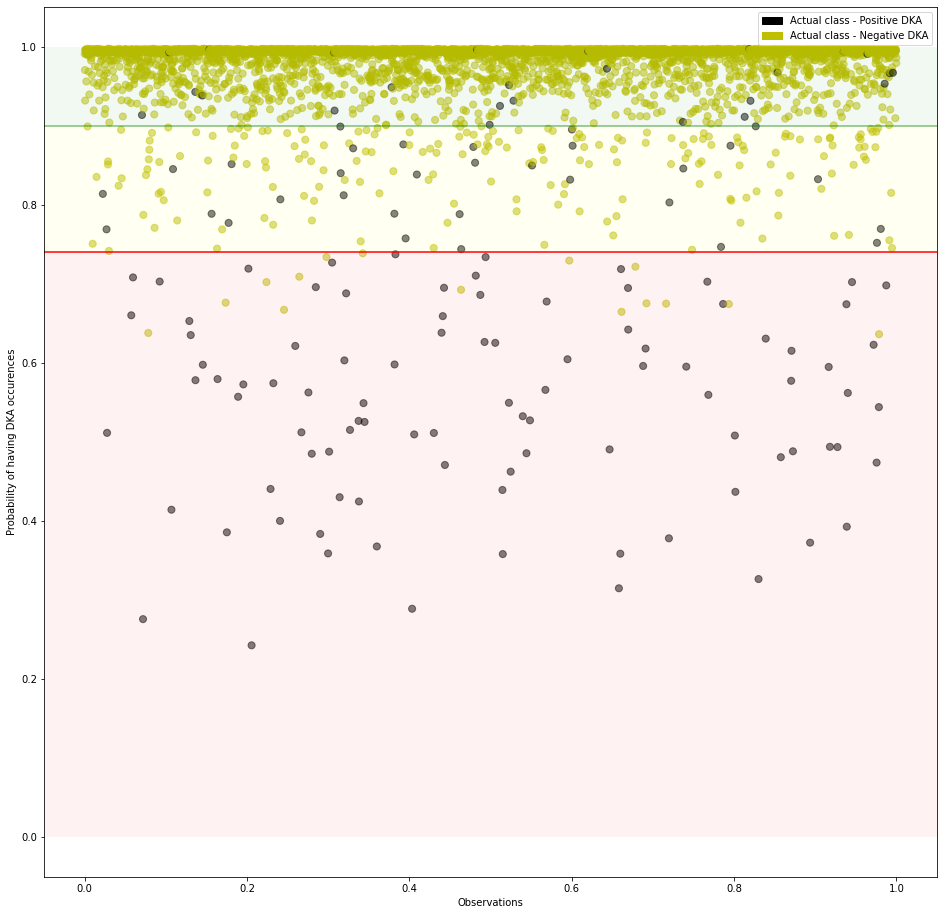

In [126]:
number_of_patients = X_train_copy.shape[0]

def get_optimal_threshold(model, X, allocated_amount, cost_per_head):
    threshold = 0.80
    threshold2 = 0.90 # initial threshold - from ground truth 
    treatable_patient_count = int(allocated_amount / cost_per_head)
    if treatable_patient_count > number_of_patients:
        threshold = 1.0
        threshold2 = None
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[treatable_patient_count-1],2)
    return threshold, threshold2
    
thresh1, thresh2 = get_optimal_threshold(model, X_train_copy, 22000, 200)

draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)



In [37]:
def get_decision_boundaries(model, patient_data, thresh1, thresh2):
    prob = (model.predict_proba(patient_data)[:,1])
    label = ''
    if(prob < thresh1):
        label = 'high priority patient'
    elif(prob < thresh2):
        label = 'moderate priority patient'
    else:
        label = 'low priority patient'
    return label

get_decision_boundaries(model, X_train_copy.head(1), 0.7,0.9)

[0.99076834]


'low risk'

In [ ]:
number_of_patients<-X_train_copy.shape[0]

FUNCTION  get_optimal_threshold(model, X, allocated_amount, cost_per_head):
    RETURNS // What gets sent back?
    threshold<-0.80
    threshold2<-0.90 // initial threshold - from ground truth 
    treatable_patient_count<-int(allocated_amount / cost_per_head)
    IF treatable_patient_count > number_of_patients
        THEN
        threshold<-1.0
        threshold2<-None
    ELSE
        prediction<-(model.predict_proba(X)[:,1])
        prediction<-np.sort(prediction)
        threshold<-np.round(prediction[treatable_patient_count-1],2)
    ENDIF
    return threshold, threshold2
    
ENDFUNCTION

In [ ]:

FUNCTION  get_decision_boundaries(model, patient_data, thresh1, thresh2):
    RETURNS // What gets sent back?
    prob<-(model.predict_proba(patient_data)[:,1])
    label<-''
    if(prob < thresh1):
        label<-'high priority patient'
    elif(prob < thresh2):  //You will need to change this to CASE OF
        label<-'moderate priority patient'
    ELSE
        label<-'low priority patient'
    return label
ENDFUNCTION